<a href="https://colab.research.google.com/github/ShawnLiu119/BTCPred-ARIMA-RNN/blob/main/btc_timeseries_ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
###########################################################################################################
######################################## BTC - Test Run 1 #################################################
###################################### author: Shawn Liu ##################################################

In [1]:
import pandas as pd
import numpy as np
import os
import re

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
path = '/content/drive/MyDrive/BTC-Pred/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv'
df = pd.read_csv(path)

In [6]:
df.isna().sum()

Timestamp                  0
Open                 1243608
High                 1243608
Low                  1243608
Close                1243608
Volume_(BTC)         1243608
Volume_(Currency)    1243608
Weighted_Price       1243608
dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4857377 entries, 0 to 4857376
Data columns (total 8 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Timestamp          int64  
 1   Open               float64
 2   High               float64
 3   Low                float64
 4   Close              float64
 5   Volume_(BTC)       float64
 6   Volume_(Currency)  float64
 7   Weighted_Price     float64
dtypes: float64(7), int64(1)
memory usage: 296.5 MB


In [10]:
df.describe()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
count,4.857377e+06,3.613769e+06,3.613769e+06,3.613769e+06,3.613769e+06,3.613769e+06,3.613769e+06,3.613769e+06
mean,1.471301e+09,6.009024e+03,6.013357e+03,6.004488e+03,6.009014e+03,9.323249e+00,4.176284e+04,6.008935e+03
std,8.428019e+07,8.996247e+03,9.003521e+03,8.988778e+03,8.996360e+03,3.054989e+01,1.518248e+05,8.995992e+03
min,1.325318e+09,3.800000e+00,3.800000e+00,1.500000e+00,1.500000e+00,0.000000e+00,0.000000e+00,3.800000e+00
25%,1.398179e+09,4.438600e+02,4.440000e+02,4.435200e+02,4.438600e+02,4.097759e-01,4.521422e+02,4.438306e+02
50%,1.471428e+09,3.596970e+03,3.598190e+03,3.595620e+03,3.597000e+03,1.979811e+00,3.810124e+03,3.596804e+03
75%,1.544288e+09,8.627270e+03,8.632980e+03,8.621090e+03,8.627160e+03,7.278216e+00,2.569821e+04,8.627637e+03
max,1.617149e+09,6.176356e+04,6.178183e+04,6.167355e+04,6.178180e+04,5.853852e+03,1.390067e+07,6.171621e+04


Some initial first-look findings:

- a lot of NaN values
- all numeric(float) columns excpet Timestamp, similar to stock market data

## GOAL 1 - Predict BTC Price as Time Series using ARIMA

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
import statsmodels.api as sm
import warnings
from itertools import product
from datetime import datetime
warnings.filterwarnings('ignore')
plt.style.use('seaborn-poster')

In [12]:
df.Timestamp = pd.to_datetime(df.Timestamp, unit='s')   #convert unix time to normal time stamp; unit 's' represent second

In [15]:
df.index = df.Timestamp #to resample (frequency conversion) the dataset, the timeseries column needed to be set as index

df_day = df.resample('D').mean() #resample to daily frequency and aggregate with average
df_month = df.resample('M').mean()
df_quarter = df.resample('Q-DEC').mean()
df_hour = df.resample('60min').mean()

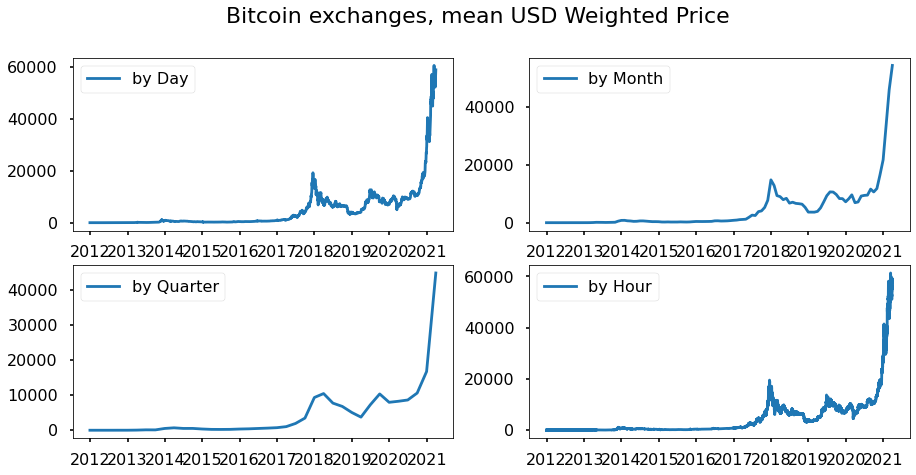

In [17]:
#plot the data

fig = plt.figure(figsize=[15,7])
plt.suptitle('Bitcoin exchanges, mean USD Weighted Price', fontsize=22)

plt.subplot(221)
plt.plot(df_day.Weighted_Price, '-', label = 'by Day') #average the weighted price per daily basis
plt.legend()

plt.subplot(222)
plt.plot(df_month.Weighted_Price, '-', label = 'by Month') #average the weighted price per monthly basis
plt.legend()

plt.subplot(223)
plt.plot(df_quarter.Weighted_Price, '-', label = 'by Quarter') #average the weighted price per quarterly basis
plt.legend()

plt.subplot(224)
plt.plot(df_hour.Weighted_Price, '-', label = 'by Hour') #average the weighted price per hourly basis
plt.legend()

plt.show()

####Stationary Check and STL-decomposiotion

(array([77., 26.,  4.,  1.,  1.,  0.,  1.,  0.,  1.,  1.]),
 array([4.47160287e+00, 5.45395266e+03, 1.09034337e+04, 1.63529148e+04,
        2.18023958e+04, 2.72518769e+04, 3.27013580e+04, 3.81508390e+04,
        4.36003201e+04, 4.90498011e+04, 5.44992822e+04]),
 <BarContainer object of 10 artists>)

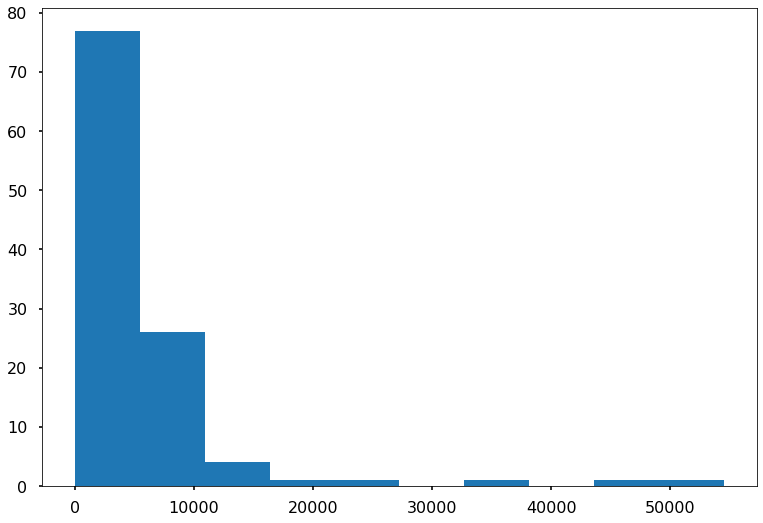

In [18]:
plt.hist(df_month.Weighted_Price)

Dickey–Fuller test: p=0.998833


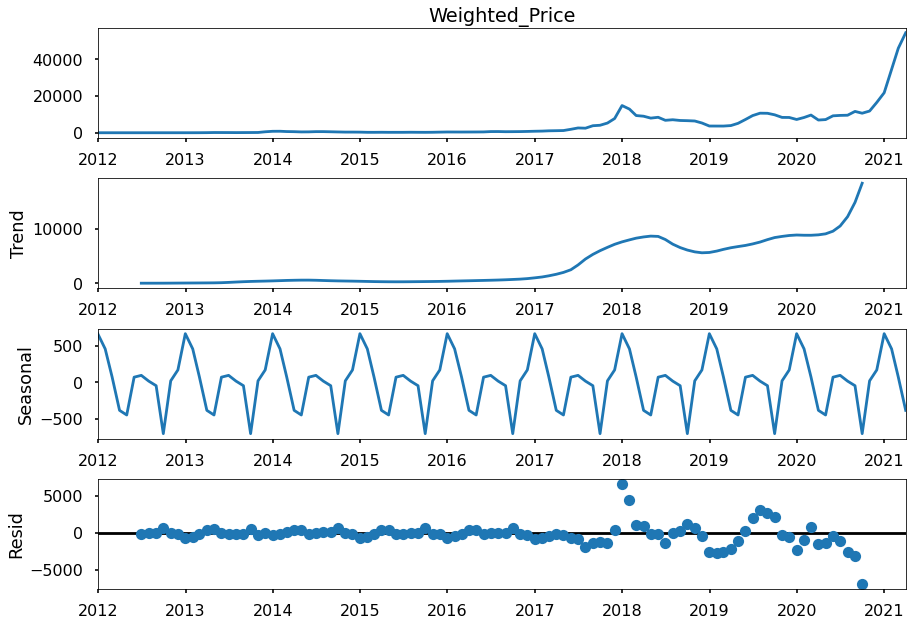

In [19]:
#using monthly data for prediction
sm.tsa.seasonal_decompose(df_month.Weighted_Price).plot()
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.Weighted_Price)[1])
plt.show()

### Stationarity Requirement ###
# - constant mean and variance
# - no trend, no seasonality
# https://towardsdatascience.com/7-statistical-tests-to-validate-and-help-to-fit-arima-model-33c5853e2e93

### ADF Test
### null hypothesis -- non-stationary
### reject(low p value) -- stationary

we can tell that the data is not statioanry

## Data Preprocessing
####Box-Cox transformation 
Box-Cox transformation is a statistical technique that transforms your target variable so that your data closely resembles a normal distribution


In [25]:
df_month['price_bctrans'], lmbda = stats.boxcox(df_month.Weighted_Price)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.price_bctrans)[1])

#If the lmbda parameter is None, the second returned argument is the lmbda that maximizes the log-likelihood function.

Dickey–Fuller test: p=0.926409


In [ ]:
#we can tell even after the box-cox transformation, the ADF test p value still high, non stationary

####Seasonal differentiation

In [29]:
df_month['price_bc_diff'] = df_month.price_bctrans - df_month.price_bctrans.shift(12) #differentiat by 12 month, so subtract the same month to remove seasonality
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.price_bc_diff[12:])[1]) #first 12 rows will be NaN due to shift

Dickey–Fuller test: p=0.442190


####Regular differentiation

Dickey–Fuller test: p=0.000025


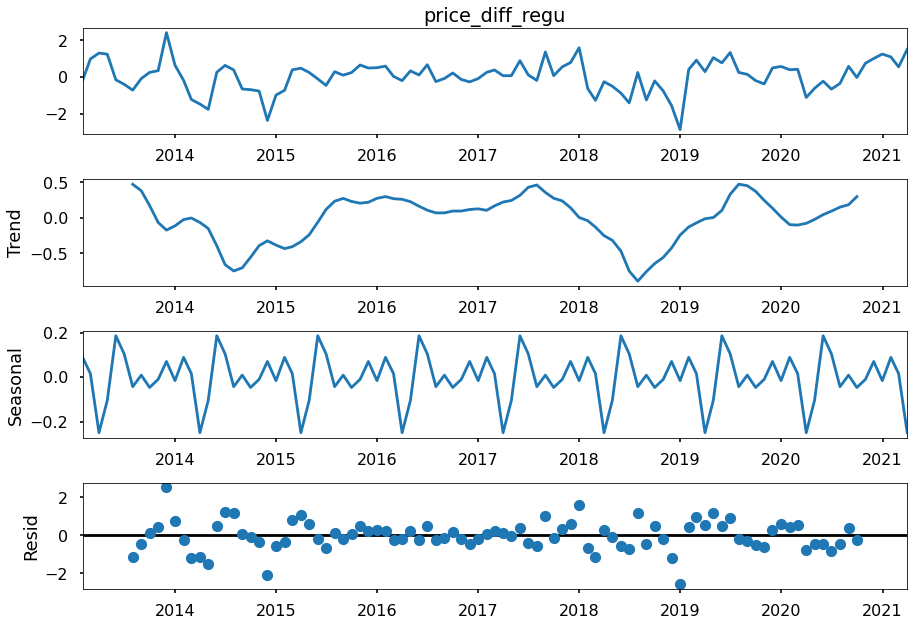

In [31]:
#diff by 1st order
df_month['price_diff_regu'] = df_month.price_bc_diff - df_month.price_bc_diff.shift(1) #the 13th row will be NaN due to shift

#STL-decomposition
sm.tsa.seasonal_decompose(df_month.price_diff_regu[13:]).plot()   
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.price_diff_regu[13:])[1])

plt.show()

In [ ]:
# we can tell, after the differentiation of 1st order, seasonality, and box cox transformation, the p value has been loweded, data get to stationary

## ARIMA Model

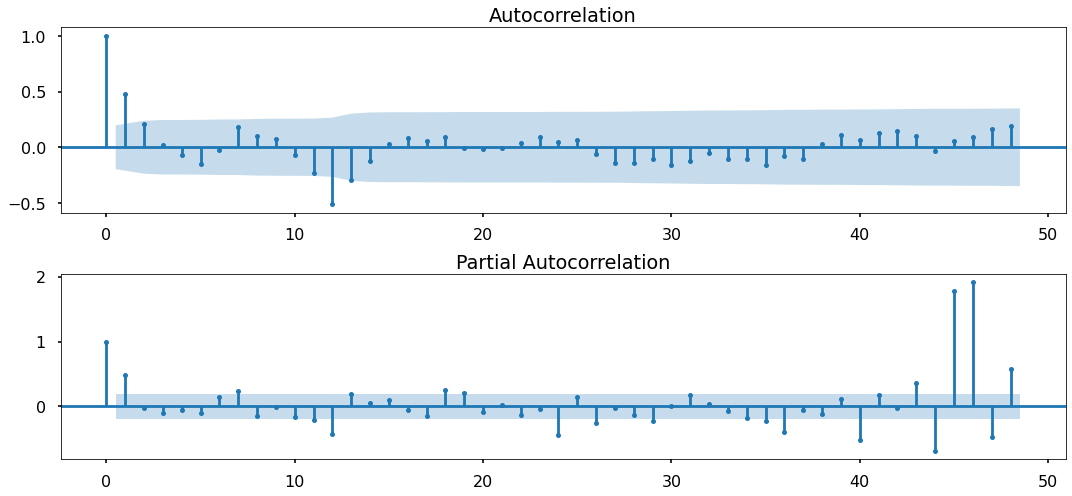

In [32]:
#initial approximation of parameters (ARIMA) using Autocorrelation & Partial Autocorrelation Plots

plt.figure(figsize=(15, 7))

ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df_month.price_diff_regu[13:].values.squeeze(), lags=48, ax=ax) #remove single-dimensional entries from the shape of an array
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df_month.price_diff_regu[13:].values.squeeze(), lags=48, ax=ax) #plot the correlation between existing and preceding 48 cycles data
plt.tight_layout()
plt.show()

In [33]:
Qs = range(0, 2) #0 or 1
qs = range(0, 3) #0, 1, 2
Ps = range(0, 3)
ps = range(0, 3)
D=1 #dffference order for seasonal component
d=1 #differnce order of the model
parameters = product(ps, qs, Ps, Qs) #product() is the iterative tools to generate set of all ordered pairs...
parameters_list = list(parameters)
len(parameters_list)

54

In [34]:
print(parameters_list)

[(0, 0, 0, 0), (0, 0, 0, 1), (0, 0, 1, 0), (0, 0, 1, 1), (0, 0, 2, 0), (0, 0, 2, 1), (0, 1, 0, 0), (0, 1, 0, 1), (0, 1, 1, 0), (0, 1, 1, 1), (0, 1, 2, 0), (0, 1, 2, 1), (0, 2, 0, 0), (0, 2, 0, 1), (0, 2, 1, 0), (0, 2, 1, 1), (0, 2, 2, 0), (0, 2, 2, 1), (1, 0, 0, 0), (1, 0, 0, 1), (1, 0, 1, 0), (1, 0, 1, 1), (1, 0, 2, 0), (1, 0, 2, 1), (1, 1, 0, 0), (1, 1, 0, 1), (1, 1, 1, 0), (1, 1, 1, 1), (1, 1, 2, 0), (1, 1, 2, 1), (1, 2, 0, 0), (1, 2, 0, 1), (1, 2, 1, 0), (1, 2, 1, 1), (1, 2, 2, 0), (1, 2, 2, 1), (2, 0, 0, 0), (2, 0, 0, 1), (2, 0, 1, 0), (2, 0, 1, 1), (2, 0, 2, 0), (2, 0, 2, 1), (2, 1, 0, 0), (2, 1, 0, 1), (2, 1, 1, 0), (2, 1, 1, 1), (2, 1, 2, 0), (2, 1, 2, 1), (2, 2, 0, 0), (2, 2, 0, 1), (2, 2, 1, 0), (2, 2, 1, 1), (2, 2, 2, 0), (2, 2, 2, 1)]


In [38]:
#model selection

results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for para in parameters_list:
  try:
    model = sm.tsa.statespace.SARIMAX(df_month.price_bctrans 
                                      ,order = (para[0], d, para[1])
                                      ,seasonal_order= (para[2], D, para[3], 12)).fit(disp=-1)
# order 
# The (p,d,q) order of the model for the number of AR parameters, differences, and MA parameters. 
# d must be an integer indicating the integration order of the process, while p and q may either be an integers indicating the AR and MA orders (so that all lags up to those orders are included) or else iterables giving specific AR and / or MA lags to include. 
# Default is an AR(1) model: (1,0,0).

# seasonal_order
# The (P,D,Q,s) order of the seasonal component of the model for the AR parameters, differences, MA parameters, and periodicity. 
# D must be an integer indicating the integration order of the process, while P and Q may either be an integers indicating the AR and MA orders (so that all lags up to those orders are included) or else iterables giving specific AR and / or MA lags to include. 
# s is an integer giving the periodicity (number of periods in season), often it is 4 for quarterly data or 12 for monthly data. Default is no seasonal effect.

  except ValueError:
    print("nonvalid parameter:", para)
    continue
  aic = model.aic
  #Akaike's Information Criterion (AIC), which was useful in selecting predictors for regression, is also useful for determining the order of an ARIMA model.
  #Lower AIC scores are better, and AIC penalizes models that use more parameters. So if two models explain the same amount of variation, the one with fewer parameters will have a lower AIC score and will be the better-fit model
  if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = para
  results.append([para, model.aic])

In [39]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())

      parameters         aic
19  (1, 0, 0, 1)  173.085878
21  (1, 0, 1, 1)  174.402438
7   (0, 1, 0, 1)  174.975324
25  (1, 1, 0, 1)  175.009844
37  (2, 0, 0, 1)  175.018971
                                      SARIMAX Results                                       
Dep. Variable:                        price_bctrans   No. Observations:                  112
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 12)   Log Likelihood                 -83.543
Date:                              Mon, 27 Feb 2023   AIC                            173.086
Time:                                      21:24:40   BIC                            180.871
Sample:                                  12-31-2011   HQIC                           176.236
                                       - 03-31-2021                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---

Dickey–Fuller test:: p=0.000000


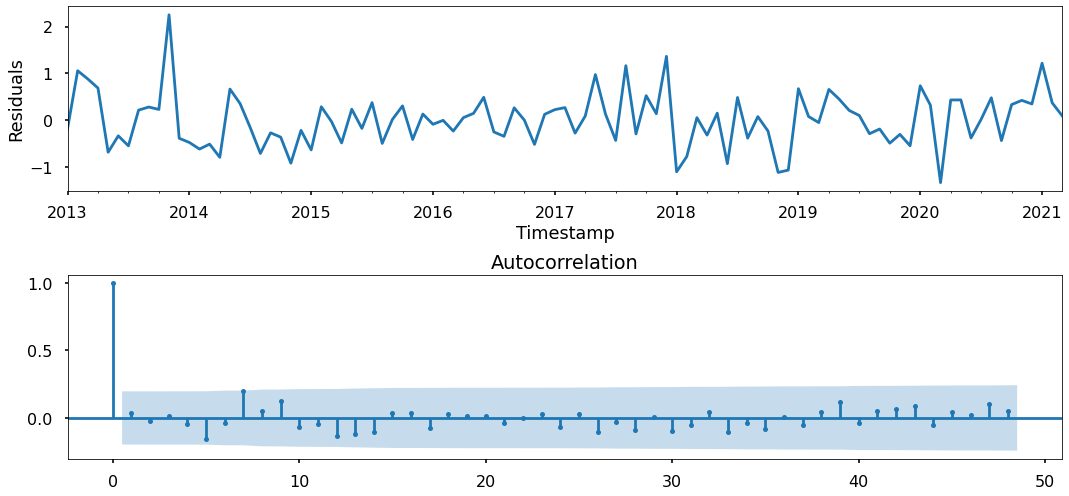

In [40]:
#residual analysis

# STL-decomposition
plt.figure(figsize=(15,7))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')
ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Dickey–Fuller test:: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

plt.tight_layout()
plt.show()

##Prediction

with best model identified, will turn this into inference

In [45]:
# Inverse Box-Cox Transformation Function
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

# #y = (x**lmbda - 1) / lmbda,  for lmbda != 0
#     log(x),                  for lmbda = 0

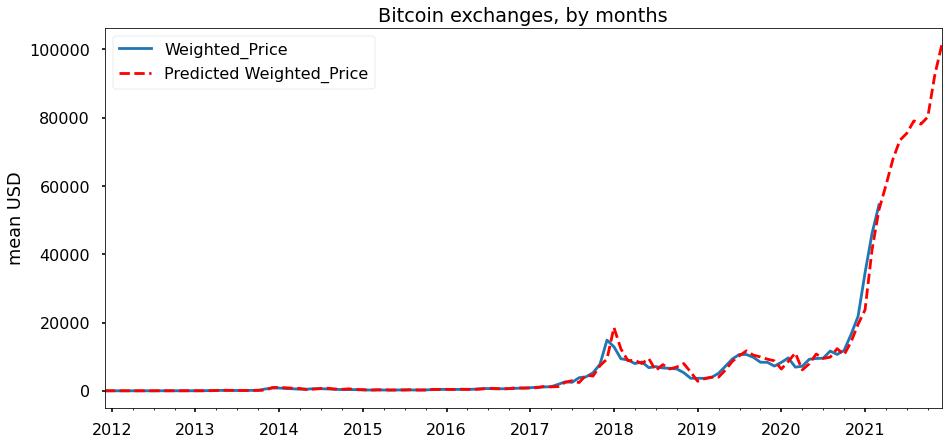

In [47]:
df_month2 = df_month[['Weighted_Price']]
date_list = [datetime(2021, 4, 30), datetime(2021, 5, 31), datetime(2021, 6, 30), datetime(2021, 7, 31), 
             datetime(2021, 8, 31), datetime(2021, 9, 30), datetime(2021, 10, 31), datetime(2021, 11, 30),
             datetime(2021, 12, 31)]
future = pd.DataFrame(index=date_list, columns= df_month2.columns)
df_month2 = pd.concat([df_month2, future])
df_month2['forecast'] = invboxcox(best_model.predict(start=0, end=len(df_month2)), lmbda)
plt.figure(figsize=(15,7))
df_month2.Weighted_Price.plot()
df_month2.forecast.plot(color='r', ls='--', label='Predicted Weighted_Price')
plt.legend()
plt.title('Bitcoin exchanges, by months')
plt.ylabel('mean USD')
plt.show()